#**Comparison of Classifier Algorithms on Bank Marketing Dataset** 

## **Install packages and libraries**







In [1]:
#to generate report in google colab and jupyter
!pip install pandas-profiling==2.7.1

     |████████████████████████████████| 252 kB 5.5 MB/s 
     |████████████████████████████████| 4.7 MB 46.1 MB/s 
     |████████████████████████████████| 675 kB 27.3 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 812 kB 38.0 MB/s 
     |████████████████████████████████| 28.5 MB 53 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=e83106e3ccd10fb67b5ca1d46254abd8d69ec754a4434daeef0868b6dec0f08d
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=46e0ae498c5f368525cedf987d3df8fcccbc94b33cfc8087227adfa9c756a2bd
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built htmlmin imagehash
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling

In [2]:
# a library that implements a variety of core algorithms and utilities for machine learning and data mining
!pip install mlxtend

In [3]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!
sns.set_style("whitegrid")
import xgboost as xgb
import pickle

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


#**Data Importing**





In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# for jupyter /Users/noufalsaeed/project classification /data/bank-full.csv
# for google colab /content/drive/MyDrive/classification/data/bank-full.csv 
DF = pd.read_csv("/content/drive/MyDrive/classification/data/bank-full.csv") 

# **Data Exploration**

In [6]:
DF.describe()

age        balance  ...         pdays      previous
count  45211.000000   45211.000000  ...  45211.000000  45211.000000
mean      40.936210    1362.272058  ...     40.197828      0.580323
std       10.618762    3044.765829  ...    100.128746      2.303441
min       18.000000   -8019.000000  ...     -1.000000      0.000000
25%       33.000000      72.000000  ...     -1.000000      0.000000
50%       39.000000     448.000000  ...     -1.000000      0.000000
75%       48.000000    1428.000000  ...     -1.000000      0.000000
max       95.000000  102127.000000  ...    871.000000    275.000000

[8 rows x 7 columns]

In the below report, we can see the data does not have any missing values or any duplicates, our data has a total number of 17 features before any data preprocessing

In [7]:
profile = ProfileReport(DF)
profile

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
DF.head()

age           job  marital  education  ... pdays  previous poutcome   y
0   58    management  married   tertiary  ...    -1         0  unknown  no
1   44    technician   single  secondary  ...    -1         0  unknown  no
2   33  entrepreneur  married  secondary  ...    -1         0  unknown  no
3   47   blue-collar  married    unknown  ...    -1         0  unknown  no
4   33       unknown   single    unknown  ...    -1         0  unknown  no

[5 rows x 17 columns]

The below code showed that our data is not balanced and in order to do classification models, we are going to balance the data by getting 5289 rows for both classes  

In [9]:
DF['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

# **Data Preprocessing**

1- Convert binary categories to 0 and 1

In [10]:
#list of variables with 2 categories:
bi_list = DF.nunique()[DF.nunique()==2].index.tolist()
print(bi_list)
for col in bi_list:
    DF[col] = DF[col].replace(DF[col].unique().tolist(),[0,1])
DF.tail(10)

['default', 'housing', 'loan', 'y']


age           job   marital  education  ...  pdays  previous  poutcome  y
45201   53    management   married   tertiary  ...    184         4   success  1
45202   34        admin.    single  secondary  ...     -1         0   unknown  1
45203   23       student    single   tertiary  ...     -1         0   unknown  1
45204   73       retired   married  secondary  ...     40         8   failure  1
45205   25    technician    single  secondary  ...     -1         0   unknown  1
45206   51    technician   married   tertiary  ...     -1         0   unknown  1
45207   71       retired  divorced    primary  ...     -1         0   unknown  1
45208   72       retired   married  secondary  ...    184         3   success  1
45209   57   blue-collar   married  secondary  ...     -1         0   unknown  0
45210   37  entrepreneur   married  secondary  ...    188        11     other  0

[10 rows x 17 columns]

2- Splitting target and data

In [11]:
#SPLITTING TARGET VALUE:
y1 = DF.y.reset_index(drop=True)
X1 = DF.drop(['y'],axis=1,inplace=False).reset_index(drop=True)
print("data:\n",X1)
print("target:\n",y1)

data:
        age           job   marital  ... pdays  previous  poutcome
0       58    management   married  ...    -1         0   unknown
1       44    technician    single  ...    -1         0   unknown
2       33  entrepreneur   married  ...    -1         0   unknown
3       47   blue-collar   married  ...    -1         0   unknown
4       33       unknown    single  ...    -1         0   unknown
...    ...           ...       ...  ...   ...       ...       ...
45206   51    technician   married  ...    -1         0   unknown
45207   71       retired  divorced  ...    -1         0   unknown
45208   72       retired   married  ...   184         3   success
45209   57   blue-collar   married  ...    -1         0   unknown
45210   37  entrepreneur   married  ...   188        11     other

[45211 rows x 16 columns]
target:
 0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64


3- Convert categories into dummies 

In [12]:
X1 = pd.get_dummies(X1, drop_first=True)
X1.head(10)

age  default  balance  ...  poutcome_other  poutcome_success  poutcome_unknown
0   58        0     2143  ...               0                 0                 1
1   44        0       29  ...               0                 0                 1
2   33        0        2  ...               0                 0                 1
3   47        0     1506  ...               0                 0                 1
4   33        0        1  ...               0                 0                 1
5   35        0      231  ...               0                 0                 1
6   28        0      447  ...               0                 0                 1
7   42        1        2  ...               0                 0                 1
8   58        0      121  ...               0                 0                 1
9   43        0      593  ...               0                 0                 1

[10 rows x 42 columns]

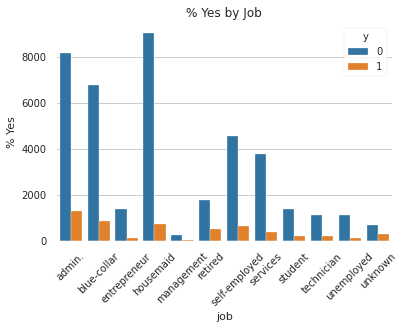

In [13]:
    
    col= DF['job']
    sns.countplot(x=DF['job'], data=DF, hue='y')
    plt.title(f'Count "y" for Job')
    if DF['job'].nunique() > 3:
            plt.xticks(rotation=45)

    job_percent =DF.groupby(col)['y'].mean()
    sns.barplot(x=job_percent.index, y=job_percent.values, palette='PuBuGn_d')
    plt.ylabel('% Yes')
    plt.title(f'% Yes by Job')
    if DF['job'].nunique() > 3:
            plt.xticks(rotation=45)

    plt.show()

4- Train-Test-Split

In [14]:
np.random.seed(10)
X_trainn,X_testt,y_trainn,y_testt = train_test_split(X1,y1,test_size=0.25, random_state=42)
X_trainn,X_testt,y_trainn,y_testt = X_trainn.reset_index(drop=True),X_testt.reset_index(drop=True),y_trainn.reset_index(drop=True),y_testt.reset_index(drop=True)

5- Data scaling

In [15]:
#Scaling columns that have values greater than 1
to_scale = [col for col in X1.columns if X1[col].max()>1]

sc = StandardScaler()

scaled_train = sc.fit_transform(X_trainn[to_scale])
scaled_train = pd.DataFrame(scaled_train,columns=to_scale)

scaled_test = sc.fit_transform(X_testt[to_scale])
scaled_test = pd.DataFrame(scaled_test,columns=to_scale)

#Replace the original columns with the scaled ones
for col in scaled_train:
    X_trainn[col] = scaled_train[col]
    X_testt[col] = scaled_test[col]

### Build Modeling Before Balancing

baseline model 

In [27]:
rf0 = RandomForestClassifier(n_estimators=100,random_state = 1)
rf0.fit(X_trainn, y_trainn)
print("Random Forest Train score: ",rf0.score(X_trainn,y_trainn))
print("Random Forest Test score: ",rf0.score(X_testt,y_testt))
y_pred_rf0 = rf0.predict(X_testt)

Random Forest Train score:  1.0
Random Forest Test score:  0.9033000088472087


In [28]:
# classification report for Random Forest 
print(classification_report(y_testt, y_pred_rf0, digits=3, zero_division = 1))
acc_rf = accuracy_score(y_testt, y_pred_rf0)
recall_rf = recall_score(y_testt, y_pred_rf0, average="binary")
print("ACCURACY:",accuracy_score(y_testt, y_pred_rf0))
print("RECALL:",recall_score(y_testt, y_pred_rf0, average="binary"))

              precision    recall  f1-score   support

           0      0.923     0.971     0.946      9950
           1      0.655     0.406     0.501      1353

    accuracy                          0.903     11303
   macro avg      0.789     0.688     0.724     11303
weighted avg      0.891     0.903     0.893     11303

ACCURACY: 0.9033000088472087
RECALL: 0.4057649667405765


Since our data is not balanced, we are going to try fitting them before balancing them to compare accuracy before and after balancing with 5 different models


*   Logistic Regression.
*   K-Nearest Neighbor.
*   Naive Bayes.
*   Decision Tree.
*   SVM.






In [16]:
# we define 2 list that one of them save results of models other list save name of model
labelList0 = []
resultList0 = []
labelList01 = []
resultList01 = []

1st Logistic Regression. 

In [17]:
lr0 = LogisticRegression(solver='liblinear')
lr0.fit(X_trainn,y_trainn)
print("Logistic Regression Test score=",lr0.score(X_testt,y_testt))
print("Logistic Regression Train score=",lr0.score(X_trainn,y_trainn))
y_pred_lr0 = lr0.predict(X_testt)
recall0 = recall_score(y_testt, y_pred_lr0, average="binary")
labelList0.append("Log_Reg")
resultList0.append(lr0.score(X_testt,y_testt))
labelList01.append("Log_Reg")
resultList01.append(recall0)
recall0

Logistic Regression Test score= 0.8983455719720428
Logistic Regression Train score= 0.9028547835319098


0.34146341463414637

In [18]:
# classification report for K-Nearest Neighbor.
print(classification_report(y_testt, y_pred_lr0, digits=3, zero_division = 1))
acc_lr = accuracy_score(y_testt, y_pred_lr0)
recall_lr = recall_score(y_testt, y_pred_lr0, average="binary")
print("ACCURACY:",accuracy_score(y_testt, y_pred_lr0))
print("RECALL:",recall_score(y_testt, y_pred_lr0, average="binary"))

              precision    recall  f1-score   support

           0      0.916     0.974     0.944      9950
           1      0.642     0.341     0.446      1353

    accuracy                          0.898     11303
   macro avg      0.779     0.658     0.695     11303
weighted avg      0.883     0.898     0.884     11303

ACCURACY: 0.8983455719720428
RECALL: 0.34146341463414637


2nd K-Nearest Neighbor.

In [19]:
knn0 = KNeighborsClassifier(n_neighbors=5) #n_neighbors = k
knn0.fit(X_trainn,y_trainn)
print("K-Nearest Neighbor Test score: ",knn0.score(X_testt,y_testt))
print("K-Nearest Neighbor Train score: ",knn0.score(X_trainn,y_trainn))
y_pred_knn0 = knn0.predict(X_testt)
labelList0.append("KNN")
resultList0.append(knn0.score(X_testt,y_testt))
recall = recall_score(y_testt, y_pred_knn0, average="binary")
labelList01.append("KNN")
resultList01.append(recall)

K-Nearest Neighbor Test score:  0.8986994603202689
K-Nearest Neighbor Train score:  0.9235578624513389


3rd Naive Bayes.

In [20]:
nb0 = GaussianNB()
nb0.fit(X_trainn,y_trainn)
print("Naive Bayes Test score: ",nb0.score(X_testt,y_testt))
print("Naive Bayes Train score: ",nb0.score(X_trainn,y_trainn))
y_pred_nb0 = nb0.predict(X_testt)
labelList0.append("Naive-B")
resultList0.append(nb0.score(X_testt,y_testt))
recall = recall_score(y_testt, y_pred_nb0, average="binary")
labelList01.append("Naive-B")
resultList01.append(recall)

Naive Bayes Test score:  0.8569406352295851
Naive Bayes Train score:  0.862480830482482


4th Decision Tree.

In [21]:
dt0 = DecisionTreeClassifier()
dt0.fit(X_trainn,y_trainn)
print("Decison Tree Train score : ",dt0.score(X_trainn,y_trainn))
print("Decison Tree Test score : ",dt0.score(X_testt,y_testt))
y_pred_dt0 = dt0.predict(X_testt)
labelList0.append("D-Tree")
resultList0.append(dt0.score(X_testt,y_testt))
recall = recall_score(y_testt, y_pred_dt0, average="binary")
labelList01.append("D-Tree")
resultList01.append(recall)

Decison Tree Train score :  1.0
Decison Tree Test score :  0.8758736618596833


5th SVM

In [22]:
# SVM model
svm0 = SVC(random_state=3)
svm0.fit(X_trainn,y_trainn)
print("svm Train score : ",svm0.score(X_testt,y_testt))
print("svm Test score: ",svm0.score(X_testt,y_testt))
y_pred_svm0 = svm0.predict(X_testt)
# adding result and label to lists
labelList0.append("SVM")
resultList0.append(svm0.score(X_testt,y_testt))
recall = recall_score(y_testt, y_pred_svm0, average="binary")
labelList01.append("SVM")
resultList01.append(recall)

svm Train score :  0.9012651508449084
svm Test score:  0.9012651508449084


In [23]:
#rf0 = RandomForestClassifier(n_estimators=100,random_state = 1)
#rf0.fit(X_trainn, y_trainn)
#print("Random Forest Train score: ",rf0.score(X_trainn,y_trainn))
#print("Random Forest Test score: ",rf0.score(X_testt,y_testt))
#y_pred_rf0 = rf0.predict(X_testt)
#labelList0.append("Random-Forest")
#resultList0.append(rf0.score(X_testt,y_testt))

In [24]:
# gb model
#gb0 = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, random_state=22)
#gb0.fit(X_trainn,y_trainn)
#print("Gradient Boosting Train score : ",gb0.score(X_testt,y_testt))
#print("Gradient Boosting Test score: ",gb0.score(X_testt,y_testt))
# adding result and label to lists
#y_pred_gb0 = gb0.predict(X_testt)
#labelList0.append("Gradient Boosting")
#resultList0.append(gb0.score(X_testt,y_testt))

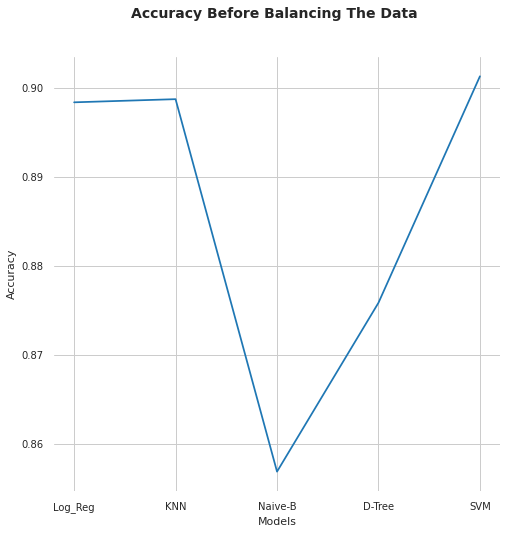

In [25]:
plt.figure(figsize=(8,8))
plt.plot(labelList0,resultList0)
plt.title("Accuracy Before Balancing The Data \n\n",fontsize=14,  fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

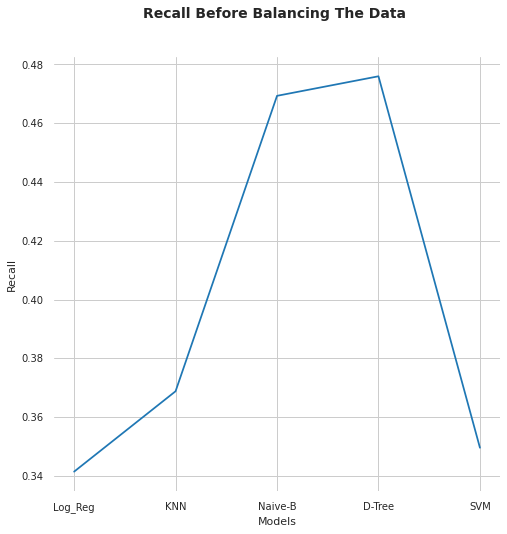

In [26]:
plt.figure(figsize=(8,8))
plt.plot(labelList01,resultList01)
plt.title("Recall Before Balancing The Data \n\n",fontsize=14,  fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Recall")
plt.show()


6- Balancing the data

In [ ]:
target = "y"
sample_size = DF[target].value_counts().min()

1    5289
0    5289
Name: y, dtype: int64

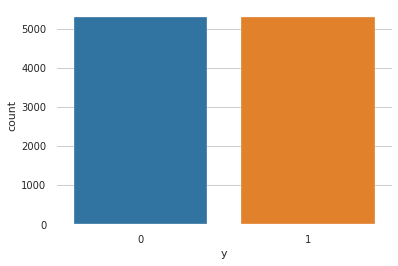

In [ ]:
balanced_data = DF.groupby('y',as_index=False, group_keys=False).apply(lambda x: x.sample(sample_size))
balanced_data = balanced_data.reset_index(drop = True)

import seaborn as sns

sns.countplot(x="y",data=balanced_data)
balanced_data.y.value_counts()

In [ ]:
balanced_data

age          job   marital  education  ...  pdays  previous  poutcome  y
0       35       admin.   married  secondary  ...     -1         0   unknown  0
1       59  blue-collar   married  secondary  ...     -1         0   unknown  0
2       36  blue-collar   married  secondary  ...     -1         0   unknown  0
3       28  blue-collar    single  secondary  ...     -1         0   unknown  0
4       29    housemaid   married    primary  ...     -1         0   unknown  0
...    ...          ...       ...        ...  ...    ...       ...       ... ..
10573   53       admin.   married  secondary  ...     -1         0   unknown  1
10574   54      retired   married    primary  ...     -1         0   unknown  1
10575   29   unemployed    single    primary  ...    178         7   success  1
10576   44    housemaid   married    primary  ...     -1         0   unknown  1
10577   57   management  divorced    unknown  ...     40         5   success  1

[10578 rows x 17 columns]

6.1 - Converting object type attributes into zeros and ones 

In [ ]:
#list of variables with 2 categories:
bi_list = balanced_data.nunique()[balanced_data.nunique()==2].index.tolist()
print(bi_list)
for col in bi_list:
    balanced_data[col] = balanced_data[col].replace(balanced_data[col].unique().tolist(),[0,1])
balanced_data.tail(10)

['default', 'housing', 'loan', 'y']


age         job   marital  education  ...  pdays  previous  poutcome  y
10568   30      admin.    single  secondary  ...     -1         0   unknown  1
10569   43      admin.   married  secondary  ...     84         3   success  1
10570   39  technician    single   tertiary  ...     -1         0   unknown  1
10571   87     retired  divorced    primary  ...     -1         0   unknown  1
10572   34      admin.   married  secondary  ...     -1         0   unknown  1
10573   53      admin.   married  secondary  ...     -1         0   unknown  1
10574   54     retired   married    primary  ...     -1         0   unknown  1
10575   29  unemployed    single    primary  ...    178         7   success  1
10576   44   housemaid   married    primary  ...     -1         0   unknown  1
10577   57  management  divorced    unknown  ...     40         5   success  1

[10 rows x 17 columns]

6.2 - Splitting target and data

In [ ]:
#SPLITTING TARGET VALUE:
y = balanced_data.y.reset_index(drop=True)
X = balanced_data.drop(['y'],axis=1,inplace=False).reset_index(drop=True)
print("data:\n",X)
print("target:\n",y)

data:
        age          job   marital  ... pdays  previous  poutcome
0       35       admin.   married  ...    -1         0   unknown
1       59  blue-collar   married  ...    -1         0   unknown
2       36  blue-collar   married  ...    -1         0   unknown
3       28  blue-collar    single  ...    -1         0   unknown
4       29    housemaid   married  ...    -1         0   unknown
...    ...          ...       ...  ...   ...       ...       ...
10573   53       admin.   married  ...    -1         0   unknown
10574   54      retired   married  ...    -1         0   unknown
10575   29   unemployed    single  ...   178         7   success
10576   44    housemaid   married  ...    -1         0   unknown
10577   57   management  divorced  ...    40         5   success

[10578 rows x 16 columns]
target:
 0        0
1        0
2        0
3        0
4        0
        ..
10573    1
10574    1
10575    1
10576    1
10577    1
Name: y, Length: 10578, dtype: int64


6.3- Convert categories into dummies

In [ ]:
X = pd.get_dummies(X, drop_first=False)
X.head(10)

age  default  balance  ...  poutcome_other  poutcome_success  poutcome_unknown
0   35        0     1476  ...               0                 0                 1
1   59        0       57  ...               0                 0                 1
2   36        0     1482  ...               0                 0                 1
3   28        0       38  ...               0                 0                 1
4   29        0        7  ...               0                 0                 1
5   53        0       46  ...               0                 0                 1
6   36        0     -417  ...               0                 0                 1
7   78        0      631  ...               0                 0                 1
8   42        0      130  ...               0                 0                 1
9   27        0       16  ...               0                 0                 1

[10 rows x 48 columns]

In [ ]:
X.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

6.4- Train-Test-Split

In [ ]:
np.random.seed(10)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train,X_test,y_train,y_test = X_train.reset_index(drop=True),X_test.reset_index(drop=True),y_train.reset_index(drop=True),y_test.reset_index(drop=True)


6.5- Feature scaling

In [ ]:
#Scaling columns that have values greater than 1
to_scale = [col for col in X.columns if X[col].max()>1]

sc = StandardScaler()

scaled_train = sc.fit_transform(X_train[to_scale])
scaled_train = pd.DataFrame(scaled_train,columns=to_scale)

scaled_test = sc.fit_transform(X_test[to_scale])
scaled_test = pd.DataFrame(scaled_test,columns=to_scale)

#Replace the original columns with the scaled ones
for col in scaled_train:
    X_train[col] = scaled_train[col]
    X_test[col] = scaled_test[col]

7- Dimensionality Reduction to improve performance 

In [ ]:
"""
PCA
Often creating dummy variables increases the number of features significantly, slowing down our model training. 
In such cases, we can apply Principle Component Analysis to remove less significant features

print("Initial dimension:\nTrain data:{}\nTest data:{}".format(X_train.shape,X_test.shape))
print()

from sklearn.decomposition import PCA

pca = PCA(n_components="mle",svd_solver="full")

X_train = pca.fit_transform(X_train)
print("Explained variance ratio for train data:\n",pca.explained_variance_ratio_)
print()
X_test = pca.fit_transform(X_test)
print("Explained variance ratio for test data:\n",pca.explained_variance_ratio_)
print()
print("Dimension after PCA:\nTrain data:{}\nTest data:{}".format(X_train.shape,X_test.shape))
"""

'\nPCA\nOften creating dummy variables increases the number of features significantly, slowing down our model training. \nIn such cases, we can apply Principle Component Analysis to remove less significant features\n\nprint("Initial dimension:\nTrain data:{}\nTest data:{}".format(X_train.shape,X_test.shape))\nprint()\n\nfrom sklearn.decomposition import PCA\n\npca = PCA(n_components="mle",svd_solver="full")\n\nX_train = pca.fit_transform(X_train)\nprint("Explained variance ratio for train data:\n",pca.explained_variance_ratio_)\nprint()\nX_test = pca.fit_transform(X_test)\nprint("Explained variance ratio for test data:\n",pca.explained_variance_ratio_)\nprint()\nprint("Dimension after PCA:\nTrain data:{}\nTest data:{}".format(X_train.shape,X_test.shape))\n'

# Data Modeling

We now compare different types of classifiers:

*   Logistic Regression.
*   K-Nearest Neighbor.
*   Naive Bayes.
*   Decision Tree.
*   SVM

Ensemble methods: 

*   Random forest. 
*   Gradient Boosting. 
*   Gradient Boosting Machines XGB
*   Stacking 

---



In [ ]:
# we define 2 list that one of them save results of models other list save name of model
labelList = []
resultList = []
labelList2 = []
resultList2 = []

defining sunction to evaluate the models

In [ ]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

# **1- Classifiers** 

1st **Logistic Regression**

In [ ]:
lr = LogisticRegression(random_state=0,solver='liblinear')
lr.fit(X_train,y_train)
print("Logistic Regression Test score=",lr.score(X_test,y_test))
print("Logistic Regression Train score=",lr.score(X_train,y_train))
y_pred_lr = lr.predict(X_test)
labelList.append("Log_Reg")
resultList.append(lr.score(X_test,y_test))
recall= recall_score(y_test, y_pred_lr, average="binary")
labelList2.append("Log_Reg")
resultList2.append(lr.score(X_test,y_test)) 

Logistic Regression Test score= 0.8383742911153119
Logistic Regression Train score= 0.8351453557078705


evaluating the model

In [ ]:
# classification report for Logistic Regression
print(classification_report(y_test, y_pred_lr, digits=3, zero_division = 1))
print("ACCURACY:",accuracy_score(y_test, y_pred_lr))
print("RECALL:",recall_score(y_test, y_pred_lr, average="binary"))

              precision    recall  f1-score   support

           0      0.840     0.848     0.844      1092
           1      0.836     0.828     0.832      1024

    accuracy                          0.838      2116
   macro avg      0.838     0.838     0.838      2116
weighted avg      0.838     0.838     0.838      2116

ACCURACY: 0.8383742911153119
RECALL: 0.828125


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Log_Reg'], 'accuracy': accuracy_score(y_test, y_pred_lr), 'recall': recall_score(y_test, y_pred_lr, average="binary")})
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf

Method  accuracy    recall
0  Log_Reg  0.838374  0.828125

In [ ]:
fprLR, tprLR, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1] )
aucScoreLR = roc_auc_score(y_test,  lr.predict_proba(X_test)[:,1])

In [ ]:
lg_eval = evaluate_model(lr, X_test, y_test)

confusion matrix for Logistic Regression:

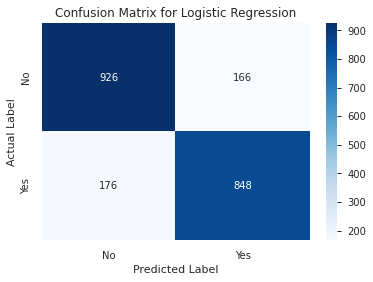

In [ ]:
predictions = lr.predict(X_test)
cm=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

2nd **K-Nearest Neighbor.**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3) #n_neighbors = k
knn.fit(X_train,y_train)
print("K-Nearest Neighbor Test score: ",knn.score(X_test,y_test))
print("K-Nearest Neighbor Train score: ",knn.score(X_train,y_train))
y_pred_knn = knn.predict(X_test)

K-Nearest Neighbor Test score:  0.8100189035916824
K-Nearest Neighbor Train score:  0.8922240605057906


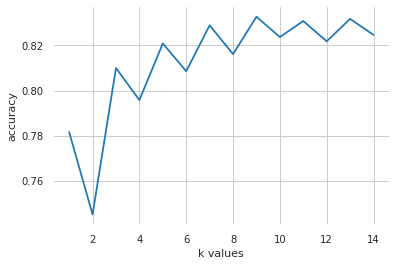

In [ ]:
# Finding optimum k value between 1 and 15
score_list = []
for each in range(1,15):
    knn2 = KNeighborsClassifier(n_neighbors = each) # create a new knn model
    knn2.fit(X_train,y_train)
    score_list.append(knn2.score(X_test,y_test))

plt.plot(range(1,15),score_list) # x axis is in interval of 1 and 15
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# finding max value in a list and it's index.
a = max(score_list) # finding max value in list
b = score_list.index(a)+1 # index of max value.

print("k = ",b," and maximum value is ", a)

k =  9  and maximum value is  0.832703213610586


In [ ]:
knn = KNeighborsClassifier(n_neighbors=9) #n_neighbors = k = 9
knn.fit(X_train,y_train)
print("K-Nearest Neighbor Test score: ",knn.score(X_test,y_test))
print("K-Nearest Neighbor Train score: ",knn.score(X_train,y_train))
y_pred_knn = knn.predict(X_test)
labelList.append("KNN")
resultList.append(knn.score(X_test,y_test))
recall= recall_score(y_test, y_pred_knn, average="binary")
labelList2.append("KNN")
resultList2.append(knn.score(X_test,y_test)) 

K-Nearest Neighbor Test score:  0.832703213610586
K-Nearest Neighbor Train score:  0.8567714488300638


In [ ]:
# classification report for K-Nearest Neighbor.
print(classification_report(y_test, y_pred_knn, digits=3, zero_division = 1))
acc_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn, average="binary")
print("ACCURACY:",accuracy_score(y_test, y_pred_knn))
print("RECALL:",recall_score(y_test, y_pred_knn, average="binary"))

              precision    recall  f1-score   support

           0      0.830     0.850     0.840      1092
           1      0.836     0.814     0.825      1024

    accuracy                          0.833      2116
   macro avg      0.833     0.832     0.832      2116
weighted avg      0.833     0.833     0.833      2116

ACCURACY: 0.832703213610586
RECALL: 0.814453125


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['KNN'], 'accuracy': [acc_knn], 'recall': [recall_knn]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf

Method  accuracy    recall
0  Log_Reg  0.838374  0.828125
0      KNN  0.832703  0.814453

In [ ]:
knn_eval = evaluate_model(knn, X_test, y_test)

In [ ]:
fprKNN, tprKNN, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1] )
aucScoreKNN = roc_auc_score(y_test,  knn.predict_proba(X_test)[:,1])

confusion matrix for KNN:

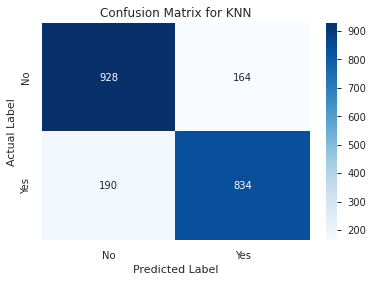

In [ ]:
predictions = knn.predict(X_test)
cm2=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm2 = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm2, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

3rd **Naive Bayes**

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)
print("Naive Bayes Test score: ",nb.score(X_test,y_test))
print("Naive Bayes Train score: ",nb.score(X_train,y_train))
y_pred_nb = nb.predict(X_test)
labelList.append("Naive-B")
resultList.append(nb.score(X_test,y_test))
recall= recall_score(y_test, y_pred_nb, average="binary")
labelList2.append("Naive-B")
resultList2.append(nb.score(X_test,y_test)) 

Naive Bayes Test score:  0.7344045368620038
Naive Bayes Train score:  0.7279602930749232


In [ ]:
# classification report for Naive Bayes
print(classification_report(y_test, y_pred_nb, digits=3, zero_division = 1))
acc_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb, average="binary")
print("ACCURACY:",accuracy_score(y_test, y_pred_nb))
print("RECALL:",recall_score(y_test, y_pred_nb, average="binary"))

              precision    recall  f1-score   support

           0      0.697     0.860     0.770      1092
           1      0.801     0.601     0.686      1024

    accuracy                          0.734      2116
   macro avg      0.749     0.730     0.728      2116
weighted avg      0.747     0.734     0.729      2116

ACCURACY: 0.7344045368620038
RECALL: 0.6005859375


In [ ]:
tempResultsDf = pd.DataFrame({'Method':['Naive Bayes'], 'accuracy': [acc_nb], 'recall':[recall_nb]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf


Method  accuracy    recall
0      Log_Reg  0.838374  0.828125
0          KNN  0.832703  0.814453
0  Naive Bayes  0.734405  0.600586

In [ ]:
nb_eval = evaluate_model(nb, X_test, y_test)

In [ ]:
fprNB, tprNB, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
aucScoreNB = roc_auc_score(y_test,  nb.predict_proba(X_test)[:,1])

confusion matrix for Naive Bayes:

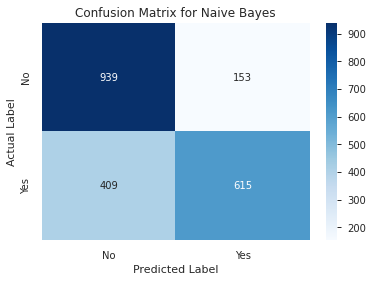

In [ ]:
predictions = nb.predict(X_test)
cm3=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm3 = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm3, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

4th **Decision Tree**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
print("Decison Tree Train score : ",dt.score(X_train,y_train))
print("Decison Tree Test score : ",dt.score(X_test,y_test))
y_pred_dt = dt.predict(X_test)
labelList.append("D-Tree")
resultList.append(dt.score(X_test,y_test))
recall= recall_score(y_test, y_pred_dt, average="binary")
labelList2.append("D-Tree")
resultList2.append(dt.score(X_test,y_test)) 

Decison Tree Train score :  1.0
Decison Tree Test score :  0.7948960302457467


In [ ]:
# classification report for decision tree 
print(classification_report(y_test, y_pred_dt, digits=3, zero_division = 1))
acc_dt = accuracy_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt, average="binary")
print("ACCURACY:",accuracy_score(y_test, y_pred_dt))
print("RECALL:",recall_score(y_test, y_pred_dt, average="binary"))

              precision    recall  f1-score   support

           0      0.797     0.808     0.803      1092
           1      0.792     0.781     0.787      1024

    accuracy                          0.795      2116
   macro avg      0.795     0.794     0.795      2116
weighted avg      0.795     0.795     0.795      2116

ACCURACY: 0.7948960302457467
RECALL: 0.78125


In [ ]:
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': [acc_dt], 'recall':[recall_dt]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

Method  accuracy    recall
0        Log_Reg  0.838374  0.828125
0            KNN  0.832703  0.814453
0    Naive Bayes  0.734405  0.600586
0  Decision Tree  0.794896  0.781250

In [ ]:
dt_eval = evaluate_model(dt, X_test, y_test)

In [ ]:
fprDT, tprDT, thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1] )
aucScoreDT = roc_auc_score(y_test,  dt.predict_proba(X_test)[:,1])

confusion matrix for Decision Tree:

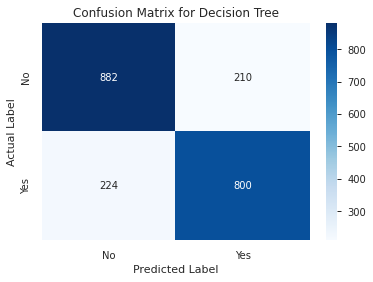

In [ ]:
predictions = dt.predict(X_test)
cm4=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm4 = pd.DataFrame(cm4, index = class_label, columns = class_label)
sns.heatmap(df_cm4, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

5th **SVM**

In [ ]:
# SVM model
svm = SVC(random_state=3, probability=True)
svm.fit(X_train,y_train)
print("svm Train score : ",svm.score(X_test,y_test))
print("svm Test score: ",svm.score(X_test,y_test))
# adding result and label to lists
y_pred_svm = svm.predict(X_test)
labelList.append("SVM")
resultList.append(svm.score(X_test,y_test))
recall= recall_score(y_test, y_pred_svm, average="binary")
labelList2.append("SVM")
resultList2.append(svm.score(X_test,y_test)) 

svm Train score :  0.8601134215500945
svm Test score:  0.8601134215500945


In [ ]:
# classification report for SVM
print(classification_report(y_test, y_pred_svm, digits=3, zero_division = 1))
acc_svm = accuracy_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm, average="binary")
print("ACCURACY:",accuracy_score(y_test, y_pred_svm))
print("RECALL:",recall_score(y_test, y_pred_svm, average="binary"))

              precision    recall  f1-score   support

           0      0.887     0.835     0.860      1092
           1      0.835     0.887     0.860      1024

    accuracy                          0.860      2116
   macro avg      0.861     0.861     0.860      2116
weighted avg      0.862     0.860     0.860      2116

ACCURACY: 0.8601134215500945
RECALL: 0.88671875


In [ ]:
tempResultsDf = pd.DataFrame({'Method':['SVM'], 'accuracy': [acc_svm], 'recall':[recall_svm]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

Method  accuracy    recall
0        Log_Reg  0.838374  0.828125
0            KNN  0.832703  0.814453
0    Naive Bayes  0.734405  0.600586
0  Decision Tree  0.794896  0.781250
0            SVM  0.860113  0.886719

In [ ]:
svm_eval = evaluate_model(svm, X_test, y_test)

In [ ]:
fprSVM, tprSVM, thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1] )
aucScoreSVM = roc_auc_score(y_test,  svm.predict_proba(X_test)[:,1])

confusion matrix for SVM:

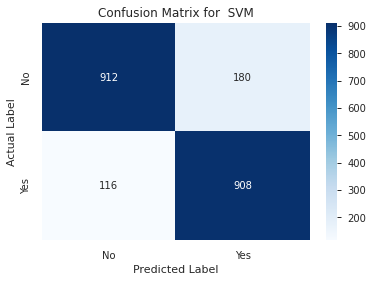

In [ ]:
predictions = svm.predict(X_test)
cm6=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm6 = pd.DataFrame(cm6, index = class_label, columns = class_label)
sns.heatmap(df_cm6, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for  SVM")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

#**Model Comparison**

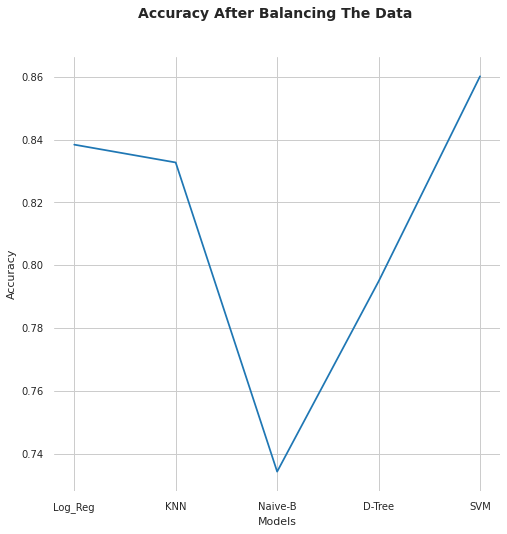

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(labelList,resultList)
plt.title("Accuracy After Balancing The Data \n\n",fontsize=14,  fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

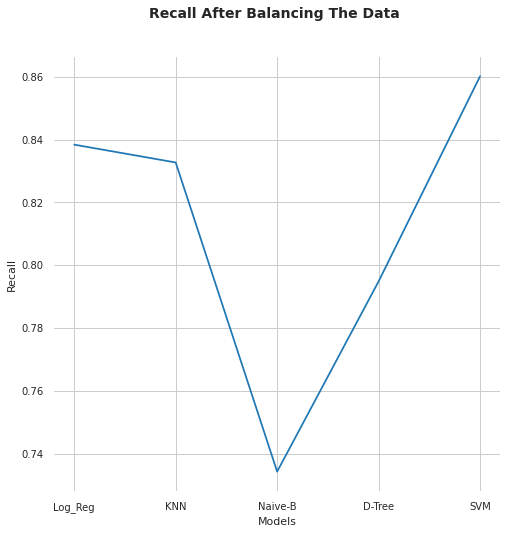

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(labelList2,resultList2)
plt.title("Recall After Balancing The Data \n\n",fontsize=14,  fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Recall")
plt.show()

# **2- Ensemble methods** 

In [ ]:
labelList_em = []
resultList_em = []

6th **Random forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100,random_state = 1)
rf.fit(X_train, y_train)
print("Random Forest Train score: ",rf.score(X_train,y_train))
print("Random Forest Test score: ",rf.score(X_test,y_test))
y_pred_rf = rf.predict(X_test)
labelList_em.append("Random-Forest")
resultList_em.append(rf.score(X_test,y_test))

Random Forest Train score:  1.0
Random Forest Test score:  0.8672022684310019


In [ ]:
# classification report for Random Forest 
print(classification_report(y_test, y_pred_rf, digits=3, zero_division = 1))
acc_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf, average="binary")
print("ACCURACY:",accuracy_score(y_test, y_pred_rf))
print("RECALL:",recall_score(y_test, y_pred_rf, average="binary"))

              precision    recall  f1-score   support

           0      0.901     0.834     0.866      1092
           1      0.836     0.902     0.868      1024

    accuracy                          0.867      2116
   macro avg      0.869     0.868     0.867      2116
weighted avg      0.870     0.867     0.867      2116

ACCURACY: 0.8672022684310019
RECALL: 0.90234375


In [ ]:
rf_eval = evaluate_model(rf, X_test, y_test)

In [ ]:
fprRF, tprRF, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1] )
aucScoreRF = roc_auc_score(y_test,  rf.predict_proba(X_test)[:,1])

confusion matrix for Random Forest:

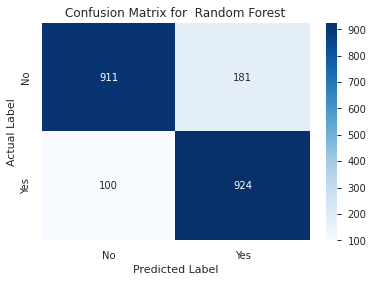

In [ ]:
predictions = rf.predict(X_test)
cm5=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm5 = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm5, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for  Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

7th **Gradient Boosting**

In [ ]:
# gb model
gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, random_state=22)
gb.fit(X_train,y_train)
print("Gradient Boosting Train score : ",gb.score(X_train,y_train))
print("Gradient Boosting Test score: ",gb.score(X_test,y_test))
# adding result and label to lists
y_pred_gb = gb.predict(X_test)
labelList_em.append("Gradient Boosting")
resultList_em.append(gb.score(X_test,y_test))

Gradient Boosting Train score :  0.881706452375325
Gradient Boosting Test score:  0.860586011342155


In [ ]:
# classification report for Gradient Boosting
print(classification_report(y_test, y_pred_gb, digits=3, zero_division = 1))
acc_gb = accuracy_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb, average="binary")
print("ACCURACY:",accuracy_score(y_test, y_pred_gb))
print("RECALL:",recall_score(y_test, y_pred_gb, average="binary"))

              precision    recall  f1-score   support

           0      0.881     0.843     0.862      1092
           1      0.840     0.879     0.859      1024

    accuracy                          0.861      2116
   macro avg      0.861     0.861     0.861      2116
weighted avg      0.861     0.861     0.861      2116

ACCURACY: 0.860586011342155
RECALL: 0.87890625


In [ ]:
gb_eval = evaluate_model(gb, X_test, y_test)

In [ ]:
fprGB, tprGB, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1] )
aucScoreGB = roc_auc_score(y_test,  gb.predict_proba(X_test)[:,1])

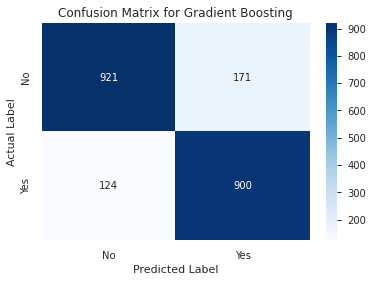

In [ ]:
predictions = gb.predict(X_test)
cm6=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm6 = pd.DataFrame(cm6, index = class_label, columns = class_label)
sns.heatmap(df_cm6, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Gradient Boosting")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

8th **Gradient Boosting Machines XGB**

In [ ]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=7,
                       objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       learning_rate=.05, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:0.486859	validation_1-rmse:0.487313
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.474608	validation_1-rmse:0.475357
[2]	validation_0-rmse:0.462798	validation_1-rmse:0.464217
[3]	validation_0-rmse:0.452011	validation_1-rmse:0.454253
[4]	validation_0-rmse:0.447512	validation_1-rmse:0.450262
[5]	validation_0-rmse:0.443017	validation_1-rmse:0.446022
[6]	validation_0-rmse:0.43983	validation_1-rmse:0.443278
[7]	validation_0-rmse:0.430281	validation_1-rmse:0.434539
[8]	validation_0-rmse:0.421497	validation_1-rmse:0.426696
[9]	validation_0-rmse:0.412849	validation_1-rmse:0.419256
[10]	validation_0-rmse:0.409931	validation_1-rmse:0.416644
[11]	validation_0-rmse:0.402057	validation_1-rmse:0.409943
[12]	validation_0-rmse:0.394772	validation_1-rmse:0.404075
[13]	validation_0-rmse:0.387788	validation_1-rmse:0.397969
[14]	validation_0-rmse:0.3

In [ ]:
#Evaluate models with Root Mean Squared Error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [ ]:
# predict using n_estimators with lowest validation error
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

0.3125508901587932

In [ ]:
rmse(gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit),y_train) 

0.21946035361966282

In [ ]:
print("Gradient Boosting Train score : ",fit_model.score(X_train,y_train))
print("Gradient Boosting Test score: ",fit_model.score(X_test,y_test))
labelList_em.append("Gradient Boosting XGB")
resultList_em.append(fit_model.score(X_test,y_test))

Gradient Boosting Train score :  0.807336171278697
Gradient Boosting Test score:  0.6088438057811919


In [ ]:
gbm.get_booster().get_score(importance_type='weight') #e


{'age': 2735,
 'balance': 2687,
 'campaign': 712,
 'contact_cellular': 183,
 'contact_telephone': 51,
 'contact_unknown': 185,
 'day': 1731,
 'default': 63,
 'duration': 3222,
 'education_primary': 124,
 'education_secondary': 141,
 'education_tertiary': 141,
 'education_unknown': 131,
 'housing': 377,
 'job_admin.': 163,
 'job_blue-collar': 121,
 'job_entrepreneur': 92,
 'job_housemaid': 72,
 'job_management': 141,
 'job_retired': 52,
 'job_self-employed': 74,
 'job_services': 122,
 'job_student': 79,
 'job_technician': 110,
 'job_unemployed': 85,
 'job_unknown': 64,
 'loan': 239,
 'marital_divorced': 143,
 'marital_married': 161,
 'marital_single': 108,
 'month_apr': 240,
 'month_aug': 241,
 'month_dec': 71,
 'month_feb': 241,
 'month_jan': 118,
 'month_jul': 180,
 'month_jun': 133,
 'month_mar': 117,
 'month_may': 178,
 'month_nov': 216,
 'month_oct': 177,
 'month_sep': 122,
 'pdays': 1185,
 'poutcome_failure': 110,
 'poutcome_other': 69,
 'poutcome_success': 271,
 'poutcome_unknown

In [ ]:
gbm.get_booster().get_score(importance_type='gain') #extract raw gain scores

{'age': 0.3364217125065371,
 'balance': 0.3147410387702119,
 'campaign': 0.43610375325415596,
 'contact_cellular': 0.5061160156706928,
 'contact_telephone': 0.6269202798072551,
 'contact_unknown': 6.124530226651897,
 'day': 0.4849403320214063,
 'default': 0.2351821956070572,
 'duration': 2.1779088932001014,
 'education_primary': 0.31438668258972585,
 'education_secondary': 0.24396917064333346,
 'education_tertiary': 0.7076047984453191,
 'education_unknown': 0.3018804596500001,
 'housing': 2.1458177585044305,
 'job_admin.': 0.22231096942610415,
 'job_blue-collar': 0.3347452471343387,
 'job_entrepreneur': 0.35798118216641306,
 'job_housemaid': 0.2545025464709764,
 'job_management': 0.1776841789745547,
 'job_retired': 0.24713896307303845,
 'job_self-employed': 0.3070587511770271,
 'job_services': 0.3018899632861476,
 'job_student': 0.5103786493406332,
 'job_technician': 0.25819673739443644,
 'job_unemployed': 0.29993971093882343,
 'job_unknown': 0.29187568696249994,
 'loan': 0.73907908629

## **9th stacking**

In [ ]:
models = ["lr", "knn", "nb", "dt", "rf", "svm","gb"]

In [ ]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"/content/drive/MyDrive/classification/models /{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [ ]:
for model_name in models:
    with open(f"/content/drive/MyDrive/classification/models /{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in models]
model_list = list(zip(models, model_vars))

In [ ]:
model_list

[('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('knn',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                       weights='uniform')),
 ('nb', GaussianNB(priors=None, var_smoothing=1e-09)),
 ('dt',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
        

In [ ]:
# Quick peek at each model performance

for model_name in models:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr score: 0.8383742911153119
knn score: 0.832703213610586
nb score: 0.7344045368620038
dt score: 0.7948960302457467
rf score: 0.8672022684310019
svm score: 0.8601134215500945
gb score: 0.860586011342155


In [ ]:
# classification report for Stacking 
print(classification_report(y_test, y_pred_rf, digits=3, zero_division = 1))
recall_st= recall_score(y_test, y_pred_rf, average="binary")
print("RECALL:",recall_score(y_test, y_pred_rf, average="binary"))

## Max Voting

In [ ]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=0,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',...
                                            

In [ ]:
# get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8596408317580341

In [ ]:
labelList_em.append("Max Voting")
resultList_em.append(voting_classifer.score(X_test,y_test))

In [ ]:
#MV_eval = evaluate_model(voting_classifer, X_test, y_test)

In [ ]:
#fprMV, tprMV, thresholds = roc_curve(y_test, voting_classifer.predict_proba(X_test)[:,1] )
#aucScoreMV = roc_auc_score(y_test,  voting_classifer.predict_proba(X_test)[:,1])

confusion matrix for Max Voting:

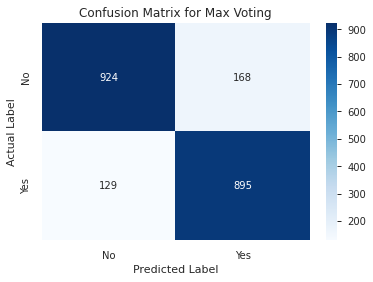

In [ ]:
predictions = voting_classifer.predict(X_test)
cm5=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm5 = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm5, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Max Voting")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

## Average Voting

In [ ]:
# create voting classifier
voting_classifer2 = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting propabilites 
                                    n_jobs=-1)
voting_classifer2.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=0,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',...
                                            

In [ ]:
# Get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_classifer2.predict(X_test)
accuracy_score(y_test, y_pred)

0.8596408317580341

In [ ]:
labelList_em.append("Average Voting")
resultList_em.append(voting_classifer2.score(X_test,y_test))

In [ ]:
AV_eval = evaluate_model(voting_classifer2, X_test, y_test)

In [ ]:
fprAV, tprAV, thresholds = roc_curve(y_test, voting_classifer2.predict_proba(X_test)[:,1] )
aucScoreAV = roc_auc_score(y_test,  voting_classifer2.predict_proba(X_test)[:,1])

confusion matrix for Average Voting:

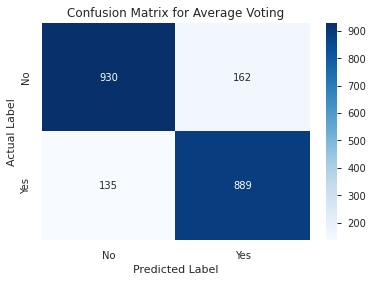

In [ ]:
predictions = voting_classifer2.predict(X_test)
cm5=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm5 = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm5, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Average Voting")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Weighted Voting

In [ ]:
# create voting classifier
weights = [0.5,1,1.5,2,3,4,5]
voting_model3 = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,  #include weights
                                    n_jobs=-1)
voting_model3.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=0,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',...
                                            

In [ ]:
# Get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_model3.predict(X_test)
accuracy_score(y_test, y_pred)

0.8653119092627599

In [ ]:
labelList_em.append("Weighted Voting")
resultList_em.append(voting_model3.score(X_test,y_test))

In [ ]:
WV_eval = evaluate_model(voting_model3, X_test, y_test)

In [ ]:
fprWV, tprWV, thresholds = roc_curve(y_test, voting_model3.predict_proba(X_test)[:,1] )
aucScoreWV = roc_auc_score(y_test,  voting_model3.predict_proba(X_test)[:,1])

confusion matrix for Weighted Voting:

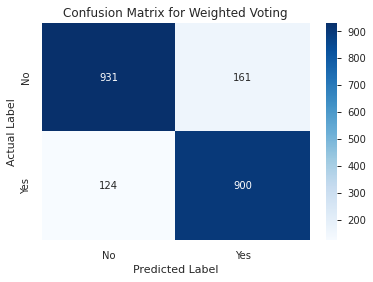

In [ ]:
predictions = voting_model3.predict(X_test)
cm5=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm5 = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm5, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Weighted Voting")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Stacking Classifier

In [ ]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)

In [ ]:
stacked.fit(X_train, y_train)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=0,
                                                   solver='liblinear',
                                                   tol=0.0001, verbose=0,
                                                   warm_start=False),
                                KNeighborsClassifier(algorithm='auto',
                                                     leaf_size=30,
                           

In [ ]:
y_pred = stacked.predict(X_test)
accuracy_score(y_test, y_pred)

0.8686200378071833

In [ ]:
labelList_em.append("Stacking")
resultList_em.append(stacked.score(X_test,y_test))

In [ ]:
S_eval = evaluate_model(stacked, X_test, y_test)

In [ ]:
fprS, tprS, thresholds = roc_curve(y_test, stacked.predict_proba(X_test)[:,1] )
aucScoreS = roc_auc_score(y_test,  stacked.predict_proba(X_test)[:,1])

confusion matrix for Stacking:

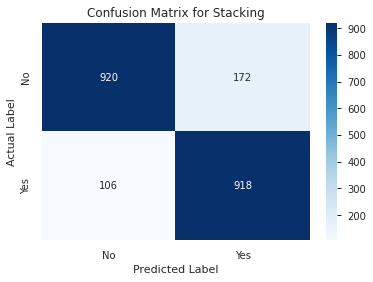

In [ ]:
predictions = stacked.predict(X_test)
cm5=confusion_matrix(y_test, predictions)
class_label = ["No", "Yes"]
df_cm5 = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm5, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Stacking")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

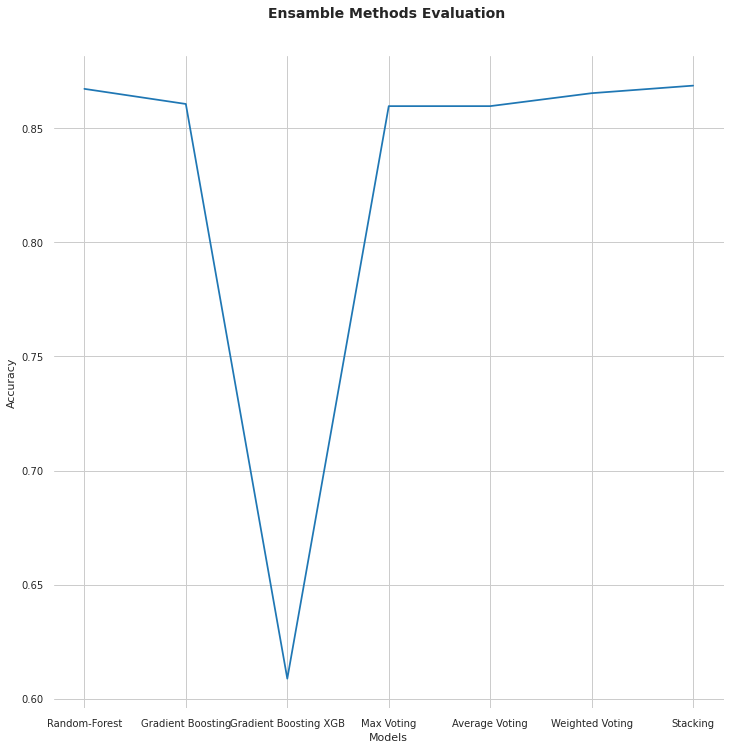

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(labelList_em,resultList_em)
plt.title("Ensamble Methods Evaluation \n\n",fontsize=14,  fontweight='bold')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

#**ROC Curve**

In [ ]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [ ]:
result_table=result_table.append({'classifiers':"KNN Classifier",'fpr':fprKNN,'tpr':tprKNN,'auc':aucScoreKNN}, ignore_index=True)
result_table=result_table.append({'classifiers':"Naive Bayes",'fpr':fprNB,'tpr':tprNB,'auc':aucScoreNB}, ignore_index=True)
result_table=result_table.append({'classifiers':"Logistic Regression",'fpr':fprLR,'tpr':tprLR,'auc':aucScoreLR}, ignore_index=True)
result_table=result_table.append({'classifiers':"Deciosion Tree",'fpr':fprDT,'tpr':tprDT,'auc':aucScoreDT}, ignore_index=True)
result_table=result_table.append({'classifiers':"Random Forest",'fpr':fprRF,'tpr':tprRF,'auc':aucScoreRF}, ignore_index=True)
result_table=result_table.append({'classifiers':"SVM",'fpr':fprSVM,'tpr':tprSVM,'auc':aucScoreSVM}, ignore_index=True)
result_table=result_table.append({'classifiers':"Gradient Boosting",'fpr':fprGB,'tpr':tprGB,'auc':aucScoreGB}, ignore_index=True)
#result_table=result_table.append({'classifiers':"Max Voting",'fpr':fprMV,'tpr':tprMV,'auc':aucScoreMV}, ignore_index=True)
result_table=result_table.append({'classifiers':"Average Voting",'fpr':fprAV,'tpr':tprAV,'auc':aucScoreAV}, ignore_index=True)
result_table=result_table.append({'classifiers':"weighted Voting",'fpr':fprWV,'tpr':tprWV,'auc':aucScoreWV}, ignore_index=True)
result_table=result_table.append({'classifiers':"Stacking",'fpr':fprS,'tpr':tprS,'auc':aucScoreS}, ignore_index=True)
result_table.set_index('classifiers', inplace=True)

## **Models**

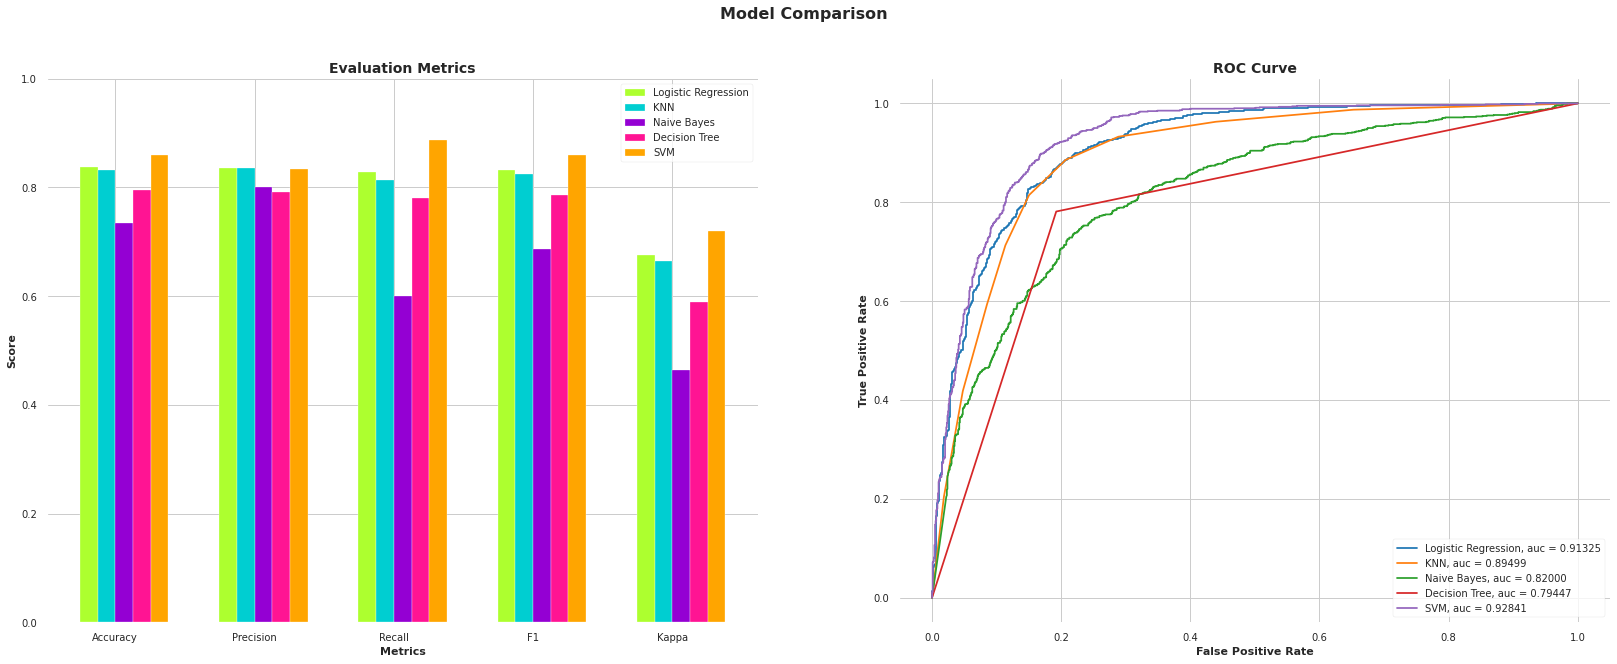

In [ ]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(10)
fig.set_figwidth(28)
fig.set_facecolor('white')



# First plot
## set bar size
barWidth = 0.127
lg_score = [lg_eval['acc'], lg_eval['prec'], lg_eval['rec'], lg_eval['f1'], lg_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
dt_score = [dt_eval['acc'], dt_eval['prec'], dt_eval['rec'], dt_eval['f1'], dt_eval['kappa']]
svm_score = [svm_eval['acc'], svm_eval['prec'], svm_eval['rec'], svm_eval['f1'], svm_eval['kappa']]


## Set position of bar on X axis
r1 = np.arange(len(lg_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]

## Make the plot
ax1.bar(r1, lg_score, width=barWidth, edgecolor='white', label='Logistic Regression',color = "greenyellow")
ax1.bar(r2, knn_score, width=barWidth, edgecolor='white', label='KNN',color = "darkturquoise")
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes', color = "darkviolet")
ax1.bar(r4, dt_score, width=barWidth, edgecolor='white', label='Decision Tree',color = "deeppink")
ax1.bar(r5, svm_score, width=barWidth, edgecolor='white', label='SVM',color = "orange")



## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(lg_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(lg_eval['fpr'], lg_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(lg_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='KNN, auc = {:0.5f}'.format(knn_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(dt_eval['fpr'], dt_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dt_eval['auc']))
ax2.plot(svm_eval['fpr'], svm_eval['tpr'], label='SVM, auc = {:0.5f}'.format(svm_eval['auc']))


## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

### **Ensemble methods**

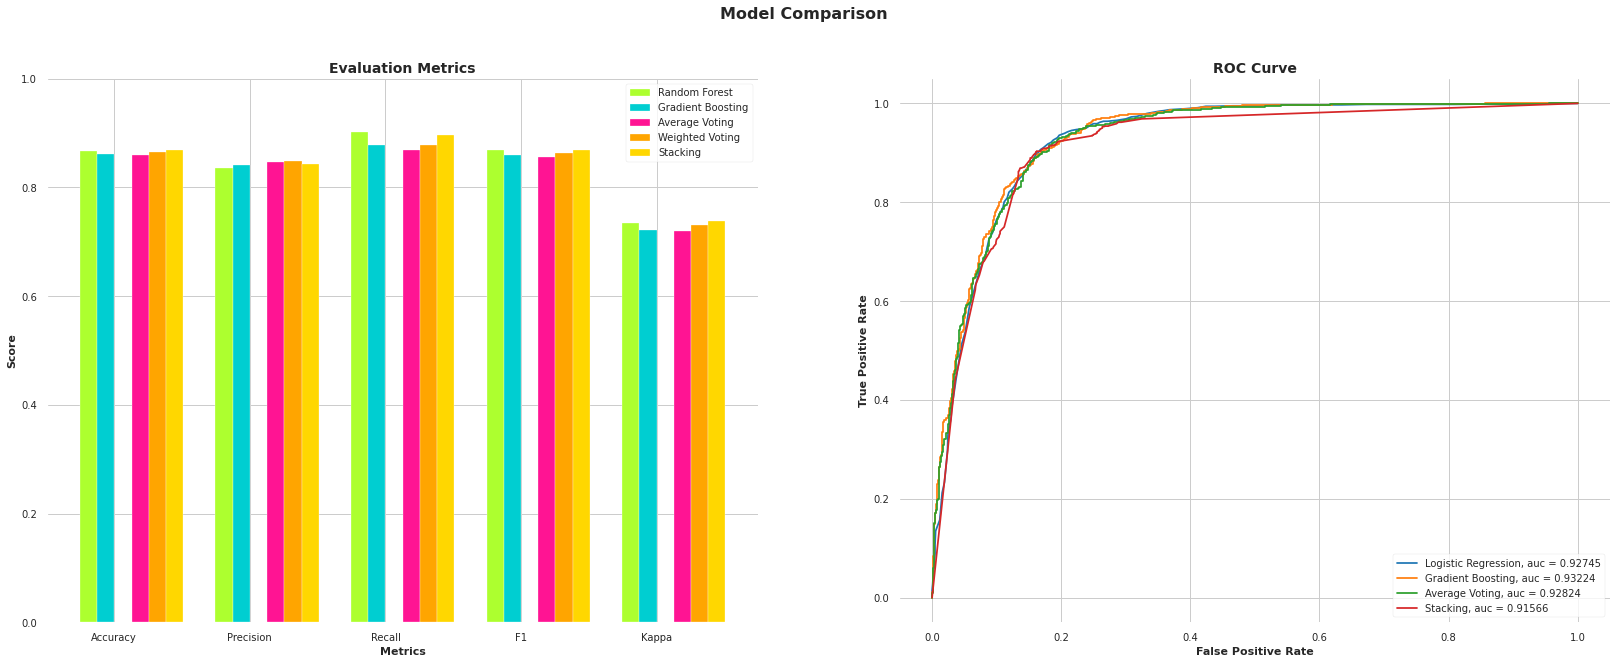

In [ ]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(10)
fig.set_figwidth(28)
fig.set_facecolor('white')



# First plot
## set bar size
barWidth = 0.127
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
gb_score = [gb_eval['acc'], gb_eval['prec'], gb_eval['rec'], gb_eval['f1'], gb_eval['kappa']]
#MV_score = [MV_eval['acc'], MV_eval['prec'], MV_eval['rec'], MV_eval['f1'], MV_eval['kappa']]
AV_score = [AV_eval['acc'], AV_eval['prec'], AV_eval['rec'], AV_eval['f1'], AV_eval['kappa']]
WV_score = [WV_eval['acc'], WV_eval['prec'], WV_eval['rec'], WV_eval['f1'], WV_eval['kappa']]
S_score = [S_eval['acc'], S_eval['prec'], S_eval['rec'], S_eval['f1'], S_eval['kappa']]



## Set position of bar on X axis
r1 = np.arange(len(lg_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest',color = "greenyellow")
ax1.bar(r2, gb_score, width=barWidth, edgecolor='white', label='Gradient Boosting',color = "darkturquoise")
#ax1.bar(r3, MV_score, width=barWidth, edgecolor='white', label='Max Voting', color = "darkviolet")
ax1.bar(r4, AV_score, width=barWidth, edgecolor='white', label='Average Voting',color = "deeppink")
ax1.bar(r5, WV_score, width=barWidth, edgecolor='white', label='Weighted Voting',color = "orange")
ax1.bar(r6, S_score, width=barWidth, edgecolor='white', label='Stacking',color = "gold")



## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(lg_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(gb_eval['fpr'], gb_eval['tpr'], label='Gradient Boosting, auc = {:0.5f}'.format(gb_eval['auc']))
#ax2.plot(MV_eval['fpr'], MV_eval['tpr'], label='Max Voting, auc = {:0.5f}'.format(MV_eval['auc']))
ax2.plot(AV_eval['fpr'], AV_eval['tpr'], label='Average Voting, auc = {:0.5f}'.format(AV_eval['auc']))
#ax2.plot(WV_score['fpr'], WV_score['tpr'], label='Weighted Voting, auc = {:0.5f}'.format(WV_score['auc']))
ax2.plot(S_eval['fpr'], S_eval['tpr'], label='Stacking, auc = {:0.5f}'.format(S_eval['auc']))



## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

In [ ]:
print('Recall For Logistic Regression = ', lg_eval['rec'])
print('Recall For KNN = ', knn_eval['rec'])
print('Recall For NB = ', nb_eval['rec'])
print('Recall For DT = ', dt_eval['rec'])
print('Recall For SVM = ', svm_eval['rec'])
print('Recall For Random Forest = ', rf_eval['rec'])
print('Recall For GB = ', gb_eval['rec'])
print('Recall For AV = ', AV_eval['rec'])
print('Recall For WV = ', WV_eval['rec'])
print('Recall For Stacking = ', S_eval['rec'])


Recall For Logistic Regression =  0.828125
Recall For KNN =  0.814453125
Recall For NB =  0.6005859375
Recall For DT =  0.78125
Recall For SVM =  0.88671875
Recall For Random Forest =  0.90234375
Recall For GB =  0.87890625
Recall For AV =  0.8681640625
Recall For WV =  0.87890625
Recall For Stacking =  0.896484375


In [ ]:
print('Acc For Logistic Regression = ', lg_eval['acc'])
print('Acc For KNN = ', knn_eval['acc'])
print('Acc For NB = ', nb_eval['acc'])
print('ACC For DT = ', dt_eval['acc'])
print('ACC For SVM = ', svm_eval['acc'])
print('ACC For Random Forest = ', rf_eval['acc'])
print('ACC For GB = ', gb_eval['acc'])
print('ACC For AV = ', AV_eval['acc'])
print('ACC For WV = ', WV_eval['acc'])
print('ACC For Stacking = ', S_eval['acc'])

Acc For Logistic Regression =  0.8383742911153119
Acc For KNN =  0.832703213610586
Acc For NB =  0.7344045368620038
ACC For DT =  0.7948960302457467
ACC For SVM =  0.8601134215500945
ACC For Random Forest =  0.8672022684310019
ACC For GB =  0.860586011342155
ACC For AV =  0.8596408317580341
ACC For WV =  0.8653119092627599
ACC For Stacking =  0.8686200378071833


In [ ]:
print('F1 For Logistic Regression = ', lg_eval['f1'])
print('F1 For KNN = ', knn_eval['f1'])
print('F1 For NB = ', nb_eval['f1'])
print('F1 For DT = ', dt_eval['f1'])
print('F1 For SVM = ', svm_eval['f1'])
print('F1 For Random Forest = ', rf_eval['f1'])
print('F1 For GB = ', gb_eval['f1'])
print('F1 For AV = ', AV_eval['f1'])
print('F1 For WV = ', WV_eval['f1'])
print('F1 For Stacking = ', S_eval['f1'])

F1 For Logistic Regression =  0.8321884200196271
F1 For KNN =  0.8249258160237388
F1 For NB =  0.6863839285714286
F1 For DT =  0.7866273352999017
F1 For SVM =  0.8598484848484849
F1 For Random Forest =  0.8680131517144198
F1 For GB =  0.8591885441527446
F1 For AV =  0.856867469879518
F1 For WV =  0.8633093525179856
F1 For Stacking =  0.8684957426679282


In [ ]:
print('prec For Logistic Regression = ', lg_eval['prec'])
print('prec For KNN = ', knn_eval['prec'])
print('prec For NB = ', nb_eval['prec'])
print('prec For DT = ', dt_eval['prec'])
print('prec For SVM = ', svm_eval['prec'])
print('prec For Random Forest = ', rf_eval['prec'])
print('prec For GB = ', gb_eval['prec'])
print('prec For AV = ', AV_eval['prec'])
print('prec For WV = ', WV_eval['prec'])
print('prec For Stacking = ', S_eval['prec'])

prec For Logistic Regression =  0.8362919132149902
prec For KNN =  0.8356713426853707
prec For NB =  0.80078125
prec For DT =  0.7920792079207921
prec For SVM =  0.8345588235294118
prec For Random Forest =  0.8361990950226245
prec For GB =  0.8403361344537815
prec For AV =  0.845861084681256
prec For WV =  0.8482563619227145
prec For Stacking =  0.8422018348623853


In [ ]:
print('kappa For Logistic Regression = ', lg_eval['kappa'])
print('kappa For KNN = ', knn_eval['kappa'])
print('kappa For NB = ', nb_eval['kappa'])
print('kappa For DT = ', dt_eval['kappa'])
print('kappa For SVM = ', svm_eval['kappa'])
print('kappa For Random Forest = ', rf_eval['kappa'])
print('kappa For GB = ', gb_eval['kappa'])
print('kappa For AV = ', AV_eval['kappa'])
print('kappa For WV = ', WV_eval['kappa'])
print('kappa For Stacking = ', S_eval['kappa'])

kappa For Logistic Regression =  0.6763159872185267
kappa For KNN =  0.664795529318264
kappa For NB =  0.46408845754499306
kappa For DT =  0.5891931160600216
kappa For SVM =  0.7204815491831371
kappa For Random Forest =  0.7347831594648169
kappa For GB =  0.7212820792172929
kappa For AV =  0.7192219642828421
kappa For WV =  0.7306483627015024
kappa For Stacking =  0.7374952251412823


From the figures above, we can see that our Random Forest and stacking models are the top metrics of other models and are very similar. So we can assume that Random Forest (Base Line) is the right choice to solve our problem.

##**Model Optimisation**

We will use GridSearchCV to find the optimal parameter for our model.

Tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# Create a base model
rf_grids = RandomForestClassifier(random_state=0)

# Initiate the grid search model
grid_search = GridSearchCV(estimator=rf_grids, param_grid=param_grid, scoring='recall',
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 24.3min finished


{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 500}

Evaluating Optimised Model

In [ ]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, X_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Cohens Kappa Score:', best_grid_eval['kappa'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.8629489603024575
Precision: 0.8259325044404974
Recall: 0.908203125
F1 Score: 0.8651162790697675
Cohens Kappa Score: 0.7264629001601175
Area Under Curve: 0.9267756982600732
Confusion Matrix:
 [[896 196]
 [ 94 930]]


Confusion matrix for optimised model

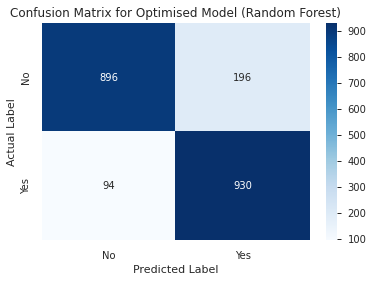

In [ ]:
best_grid_eval = evaluate_model(best_grid, X_test, y_test)
res=best_grid_eval['cm']
class_label = ["No", "Yes"]
df_cm5 = pd.DataFrame(res, index = class_label, columns = class_label)
sns.heatmap(df_cm5, annot = True, fmt = "d", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Optimised Model (Random Forest)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

Model Comparison

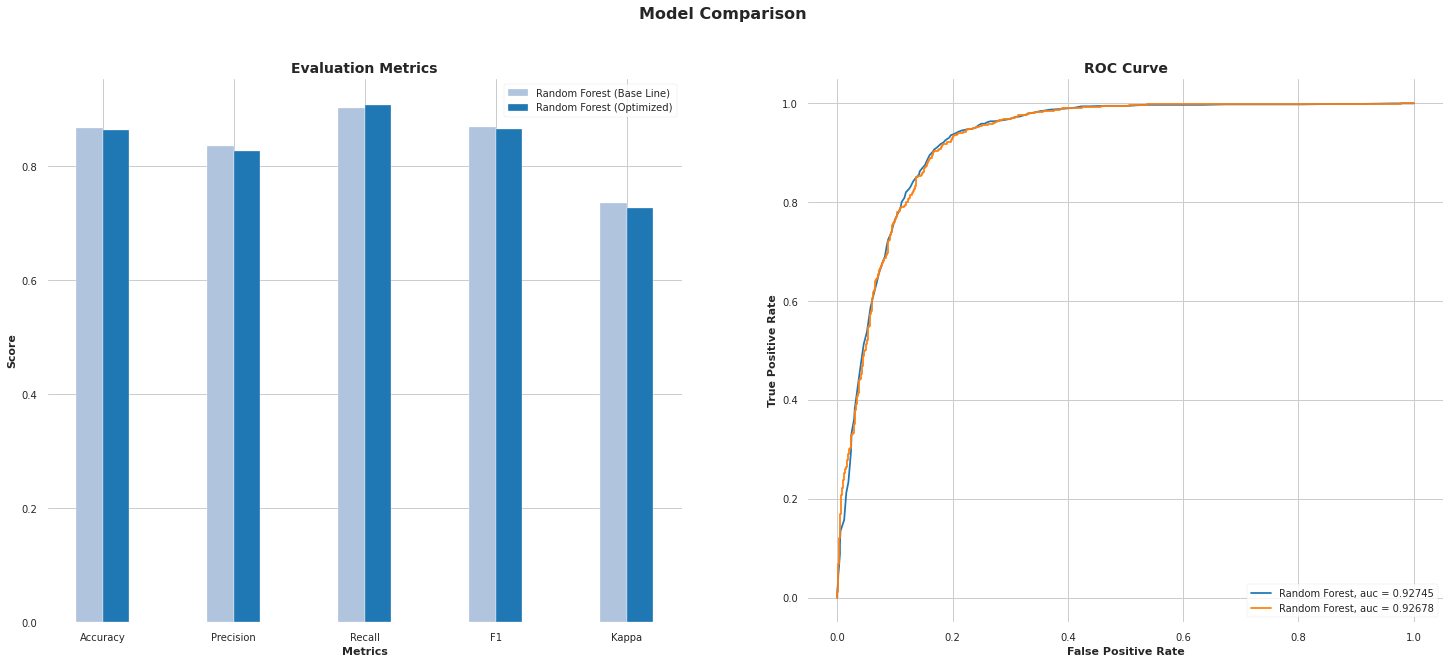

Change of -0.49% on accuracy.
Change of -1.23% on precision.
Change of 0.65% on recall.
Change of -0.33% on F1 score.
Change of -1.13% on Kappa score.
Change of -0.07% on AUC.


In [ ]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(10)
fig.set_figwidth(25)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1'], best_grid_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)', color = "lightsteelblue")
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(rf_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - rf_eval['acc']) / rf_eval['acc'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - rf_eval['prec']) / rf_eval['prec'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - rf_eval['rec']) / rf_eval['rec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - rf_eval['f1']) / rf_eval['f1'])))
print('Change of {:0.2f}% on Kappa score.'.format(100 * ((best_grid_eval['kappa'] - rf_eval['kappa']) / rf_eval['kappa'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - rf_eval['auc']) / rf_eval['auc'])))